In [1]:
from imports import *

# Fetch dataset

In [2]:
target_anomaly_rate = 0.1

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
n_records = int(np.ceil(len(df_normal)*target_anomaly_rate))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train, x_test, y_train, y_test = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 9.1% out of 1070058 records (97278)


Just like with sklearn SA dataset, we selected all of the 'normal' data with a small portion of outliers to reach our target anomaly rate

# Cross-validation for Isolation Forest

In [3]:
def cross_validation(contamination):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
print(set(np.array(y_test)))

{1, -1}


In [5]:
contamination = [0.01]
c_max = cross_validation(contamination)
c_max

1354
contamination: 0.01 	 tp: 1354/32011 -> fp = 30657
AUC : 51.8% 	 precision: 0.386 	 recall: 0.0423 	 f1: 0.07623659243827595
--------------------


0.01

In [6]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation(contamination)
c_max

1354
contamination: 0.01 	 tp: 1354/32011 -> fp = 30657
AUC : 51.8% 	 precision: 0.386 	 recall: 0.0423 	 f1: 0.07623659243827595
--------------------
2793
contamination: 0.02 	 tp: 2793/32011 -> fp = 29218
AUC : 53.7% 	 precision: 0.398 	 recall: 0.0873 	 f1: 0.1430950124241105
--------------------
4025
contamination: 0.03 	 tp: 4025/32011 -> fp = 27986
AUC : 55.2% 	 precision: 0.376 	 recall: 0.126 	 f1: 0.1883922302831734
--------------------
5422
contamination: 0.04 	 tp: 5422/32011 -> fp = 26589
AUC : 57.1% 	 precision: 0.382 	 recall: 0.169 	 f1: 0.2346018216039634
--------------------
6541
contamination: 0.05 	 tp: 6541/32011 -> fp = 25470
AUC : 58.5% 	 precision: 0.371 	 recall: 0.204 	 f1: 0.2634472481221177
--------------------
7947
contamination: 0.06 	 tp: 7947/32011 -> fp = 24064
AUC : 60.4% 	 precision: 0.376 	 recall: 0.248 	 f1: 0.29916991360325257
--------------------
9159
contamination: 0.07 	 tp: 9159/32011 -> fp = 22852
AUC : 61.9% 	 precision: 0.373 	 recall: 0.286

0.08

In [7]:
contamination = [round(0.1*i, 1) for i in range(1, 7)]
c_max_2 = cross_validation(contamination)
c_max_2

10834
contamination: 0.1 	 tp: 10834/32011 -> fp = 21177
AUC : 63.1% 	 precision: 0.309 	 recall: 0.338 	 f1: 0.32285846259294027
--------------------
16243
contamination: 0.2 	 tp: 16243/32011 -> fp = 15768
AUC : 66.9% 	 precision: 0.229 	 recall: 0.507 	 f1: 0.31589490266243997
--------------------
32009
contamination: 0.3 	 tp: 32009/32011 -> fp = 2
AUC : 88.4% 	 precision: 0.301 	 recall: 1.0 	 f1: 0.4625243840762951
--------------------
32011
contamination: 0.4 	 tp: 32011/32011 -> fp = 0
AUC : 82.9% 	 precision: 0.226 	 recall: 1.0 	 f1: 0.36876483192406057
--------------------
32011
contamination: 0.5 	 tp: 32011/32011 -> fp = 0
AUC : 77.5% 	 precision: 0.181 	 recall: 1.0 	 f1: 0.3070010549534861
--------------------
32011
contamination: 0.6 	 tp: 32011/32011 -> fp = 0
AUC : 71.9% 	 precision: 0.151 	 recall: 1.0 	 f1: 0.26187009162303665
--------------------


0.3

In [8]:
c_max = c_max_2 if c_max_2 > c_max else c_max

In [9]:
contamination = [round(c_max - 0.1 + 0.01*i, 2) for i in range(11)]
c_max = cross_validation(contamination)
c_max

16243
contamination: 0.2 	 tp: 16243/32011 -> fp = 15768
AUC : 66.9% 	 precision: 0.229 	 recall: 0.507 	 f1: 0.31589490266243997
--------------------
16245
contamination: 0.21 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.22 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.23 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.24 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
32006
contamination: 0.25 	 tp: 32006/32011 -> fp = 5
AUC : 91.2% 	 precision: 0.361 	 recall: 1.0 	 f1: 0.5310039900787232
--------------------
32006
contamination: 0.26 	 tp: 32006/32011 -> fp = 5
AUC : 90.6% 	 precision: 0.347 	 recall: 1

0.25

AUC: 91.2%
              precision    recall  f1-score   support

          -1       0.36      1.00      0.53     32011
           1       1.00      0.82      0.90    321109

    accuracy                           0.84    353120
   macro avg       0.68      0.91      0.72    353120
weighted avg       0.94      0.84      0.87    353120



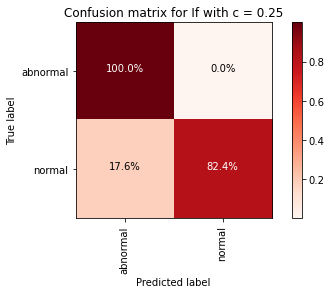

In [10]:
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c_max).fit(x_train).predict(x_test)
cm_if = confusion_matrix(y_test, y_pred)
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {c_max}")

## Cross validation for LOF 

In [11]:
def cross_validation_lof(contamination):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [12]:
contamination = [round(0.1 + 0.1*i, 2) for i in range(5)]
c_max = cross_validation_lof(contamination)
c_max

1489
contamination: 0.1 	 tp: 1489/32011 -> fp = 30522
AUC : 47.1% 	 precision: 0.0422 	 recall: 0.0465 	 f1: 0.044234511236872984
--------------------
2982
contamination: 0.2 	 tp: 2982/32011 -> fp = 29029
AUC : 44.1% 	 precision: 0.0422 	 recall: 0.0932 	 f1: 0.05810883226969357
--------------------
4495
contamination: 0.3 	 tp: 4495/32011 -> fp = 27516
AUC : 41.2% 	 precision: 0.0424 	 recall: 0.14 	 f1: 0.06516995657752615
--------------------
5412
contamination: 0.4 	 tp: 5412/32011 -> fp = 26599
AUC : 37.3% 	 precision: 0.0383 	 recall: 0.169 	 f1: 0.06247294512839159
--------------------
6244
contamination: 0.5 	 tp: 6244/32011 -> fp = 25767
AUC : 33.2% 	 precision: 0.0354 	 recall: 0.195 	 f1: 0.059874095631703345
--------------------


0.3

In [13]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation_lof(contamination)
c_max

218
contamination: 0.01 	 tp: 218/32011 -> fp = 31793
AUC : 49.8% 	 precision: 0.0625 	 recall: 0.00681 	 f1: 0.012281690140845071
--------------------
295
contamination: 0.02 	 tp: 295/32011 -> fp = 31716
AUC : 49.4% 	 precision: 0.0418 	 recall: 0.00922 	 f1: 0.015099554691098941
--------------------
596
contamination: 0.03 	 tp: 596/32011 -> fp = 31415
AUC : 49.4% 	 precision: 0.0563 	 recall: 0.0186 	 f1: 0.027977936861870674
--------------------
708
contamination: 0.04 	 tp: 708/32011 -> fp = 31303
AUC : 49.0% 	 precision: 0.0501 	 recall: 0.0221 	 f1: 0.030691867522108552
--------------------
833
contamination: 0.05 	 tp: 833/32011 -> fp = 31178
AUC : 48.7% 	 precision: 0.0472 	 recall: 0.026 	 f1: 0.033543399037590356
--------------------
940
contamination: 0.06 	 tp: 940/32011 -> fp = 31071
AUC : 48.3% 	 precision: 0.0444 	 recall: 0.0294 	 f1: 0.0353390101317694
--------------------
1101
contamination: 0.07 	 tp: 1101/32011 -> fp = 30910
AUC : 48.0% 	 precision: 0.0445 	 recal

0.03

In [14]:
c_max = 0.5

In [15]:
contamination = [round(c_max-0.01 + 0.001*i, 3) for i in range(1,10)]
c_max = cross_validation_lof(contamination)
c_max

6183
contamination: 0.491 	 tp: 6183/32011 -> fp = 25828
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.193 	 f1: 0.060206530894431655
--------------------
6198
contamination: 0.492 	 tp: 6198/32011 -> fp = 25813
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.194 	 f1: 0.060249044938905254
--------------------
6208
contamination: 0.493 	 tp: 6208/32011 -> fp = 25803
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.194 	 f1: 0.060242892978617076
--------------------
6210
contamination: 0.494 	 tp: 6210/32011 -> fp = 25801
AUC : 33.5% 	 precision: 0.0356 	 recall: 0.194 	 f1: 0.06015926220138337
--------------------
6214
contamination: 0.495 	 tp: 6214/32011 -> fp = 25797
AUC : 33.5% 	 precision: 0.0356 	 recall: 0.194 	 f1: 0.06009525881869394
--------------------
6220
contamination: 0.496 	 tp: 6220/32011 -> fp = 25791
AUC : 33.4% 	 precision: 0.0355 	 recall: 0.194 	 f1: 0.06005049261678229
--------------------
6225
contamination: 0.497 	 tp: 6225/32011 -> fp = 25786
AUC : 33.4% 	 precision: 0.0

0.492

In [16]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=0.6, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

ValueError: contamination must be in (0, 0.5], got: 0.600000

trainning LOF in 0:01:44.800334
              precision    recall  f1-score   support

     anomaly       0.04      0.19      0.06     32011
      normal       0.86      0.48      0.61    321109

    accuracy                           0.45    353120
   macro avg       0.45      0.34      0.34    353120
weighted avg       0.78      0.45      0.56    353120

AUC:  33.6%


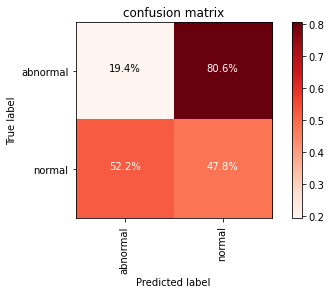

In [17]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c_max, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

# DBSCAN

Tested parameters: 
* eps

In [18]:
def cross_validation_dbscan(eps):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"eps: {e} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return best_eps

In [19]:
eps = [round(0.1 + 0.1*i, 2) for i in range(5)]
e_max = cross_validation_dbscan(eps)
e_max

8831
eps: 0.1 	 tp: 8831/32011 -> fp = 23180
AUC : 19.9% 	 precision: 0.0304 	 recall: 0.276 	 f1: 0.05469567748688506
--------------------
8788
eps: 0.2 	 tp: 8788/32011 -> fp = 23223
AUC : 19.9% 	 precision: 0.0303 	 recall: 0.275 	 f1: 0.05458808913735539
--------------------
8783
eps: 0.3 	 tp: 8783/32011 -> fp = 23228
AUC : 20.0% 	 precision: 0.0303 	 recall: 0.274 	 f1: 0.05460264962419103
--------------------
8767
eps: 0.4 	 tp: 8767/32011 -> fp = 23244
AUC : 20.0% 	 precision: 0.0303 	 recall: 0.274 	 f1: 0.05454471926610071
--------------------
8767
eps: 0.5 	 tp: 8767/32011 -> fp = 23244
AUC : 20.0% 	 precision: 0.0303 	 recall: 0.274 	 f1: 0.054574429013402384
--------------------


0.1

In [20]:
eps = [round(0.01 + 0.01*i, 2) for i in range(10)]
e_max = cross_validation_dbscan(eps)
e_max

9096
eps: 0.01 	 tp: 9096/32011 -> fp = 22915
AUC : 18.6% 	 precision: 0.0301 	 recall: 0.284 	 f1: 0.05451374530286413
--------------------
8931
eps: 0.02 	 tp: 8931/32011 -> fp = 23080
AUC : 19.1% 	 precision: 0.0301 	 recall: 0.279 	 f1: 0.05432151328994587
--------------------
8864
eps: 0.03 	 tp: 8864/32011 -> fp = 23147
AUC : 19.4% 	 precision: 0.0301 	 recall: 0.277 	 f1: 0.05429476224602928
--------------------
8860
eps: 0.04 	 tp: 8860/32011 -> fp = 23151
AUC : 19.5% 	 precision: 0.0302 	 recall: 0.277 	 f1: 0.05441157504928362
--------------------
8844
eps: 0.05 	 tp: 8844/32011 -> fp = 23167
AUC : 19.6% 	 precision: 0.0302 	 recall: 0.276 	 f1: 0.0544623200677392
--------------------
8842
eps: 0.06 	 tp: 8842/32011 -> fp = 23169
AUC : 19.7% 	 precision: 0.0303 	 recall: 0.276 	 f1: 0.05454758570485573
--------------------
8839
eps: 0.07 	 tp: 8839/32011 -> fp = 23172
AUC : 19.8% 	 precision: 0.0303 	 recall: 0.276 	 f1: 0.054602680405365756
--------------------
8836
eps: 0.0

0.1

In [21]:
e_max = 0.08

In [22]:
eps = [round(e_max-0.01 + 0.001*i, 3) for i in range(1,10)]
e_max = cross_validation_lof(contamination)
e_max

6183
contamination: 0.491 	 tp: 6183/32011 -> fp = 25828
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.193 	 f1: 0.060206530894431655
--------------------
6198
contamination: 0.492 	 tp: 6198/32011 -> fp = 25813
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.194 	 f1: 0.060249044938905254
--------------------
6208
contamination: 0.493 	 tp: 6208/32011 -> fp = 25803
AUC : 33.6% 	 precision: 0.0357 	 recall: 0.194 	 f1: 0.060242892978617076
--------------------
6210
contamination: 0.494 	 tp: 6210/32011 -> fp = 25801
AUC : 33.5% 	 precision: 0.0356 	 recall: 0.194 	 f1: 0.06015926220138337
--------------------
6214
contamination: 0.495 	 tp: 6214/32011 -> fp = 25797
AUC : 33.5% 	 precision: 0.0356 	 recall: 0.194 	 f1: 0.06009525881869394
--------------------
6220
contamination: 0.496 	 tp: 6220/32011 -> fp = 25791
AUC : 33.4% 	 precision: 0.0355 	 recall: 0.194 	 f1: 0.06005049261678229
--------------------
6225
contamination: 0.497 	 tp: 6225/32011 -> fp = 25786
AUC : 33.4% 	 precision: 0.0

0.492

In [23]:
start = datetime.datetime.now()
db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
trainning_time = datetime.datetime.now() - start
print(f"trainning Isolation Forest in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

NameError: name 'e' is not defined